In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from predict import get_prediction_filename

In [5]:
nb_folds = 5
model_name='unet_ds'
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = False

In [6]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR

In [7]:
scores_data = []
for fold_number in range(nb_folds):
    # load data
    dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)
    
    images = [dataset[i][0] for i in range(len(dataset))]
    masks = [dataset[i][1] for i in range(len(dataset))]    
    
    images = np.stack(images)
    masks = np.stack(masks)
    
    # load predictions
    filename = get_prediction_filename(model_name, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
    _, predictions = load_pickle(filename) 
    
    # get score at different thresholds
    for tr in np.arange(0.1, 1.0, 0.1):
        predictions_mask = np.zeros_like(predictions)
        predictions_mask[predictions>tr] = 1

        score = topcoder_metric(masks, predictions_mask)    
        
        scores_data.append({'score': score, 'threshold': tr, 'fold': fold_number})
    
    print(f'Fold {fold_number} finished')
        
scores_data = pd.DataFrame(scores_data)

Fold 0 finished
Fold 1 finished
Fold 2 finished
Fold 3 finished
Fold 4 finished


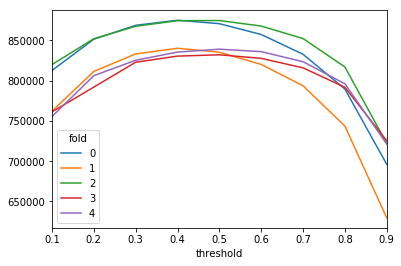

In [8]:
pd.pivot_table(scores_data, values='score', columns='fold', index='threshold').plot()

# Get scores

In [49]:
threshold = 0.3

In [50]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR
patch_size_train = 0
patch_size_predict = 0
nb_folds = 5

In [51]:
print(f'fold_number\tmodel\tuse_dice\tuse_tta\tscore')
for fold_number in range(nb_folds):
    dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)
    masks = [dataset[i][1] for i in range(len(dataset))]
    masks = np.stack(masks)

    for model in ['unet', 'tiramisu', 'unet_ds']:
        for use_tta in [True, False]:
            filename = get_prediction_filename(model, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
            _, model_predictions = load_pickle(filename)
            model_predictions_mask = np.zeros_like(model_predictions)
            model_predictions_mask[model_predictions>threshold] = 1

            score = topcoder_metric(masks, model_predictions_mask)

            print(f'{fold_number}\t{model}\t{use_dice}\t{use_tta}\t{score}')

INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 0 - 34 images


fold_number	model	use_dice	use_tta	score
0	unet	False	True	861581.9453645087
0	unet	False	False	856388.075473714
0	tiramisu	False	True	841980.7054636072
0	tiramisu	False	False	841920.7000047597
0	unet_ds	False	True	870827.7401436195


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 1 - 34 images


0	unet_ds	False	False	868688.3125803142
1	unet	False	True	828741.1650594576
1	unet	False	False	828054.5139181466
1	tiramisu	False	True	820495.5046021653
1	tiramisu	False	False	819549.0233527272
1	unet_ds	False	True	836775.9540495817


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 2 - 34 images


1	unet_ds	False	False	833179.513627391
2	unet	False	True	880977.4456099011
2	unet	False	False	877221.8103921716
2	tiramisu	False	True	864623.2980515661
2	tiramisu	False	False	865309.7979030601
2	unet_ds	False	True	867754.6401735075


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 3 - 33 images


2	unet_ds	False	False	867487.3014271458
3	unet	False	True	841106.7541555531
3	unet	False	False	839104.0363780262
3	tiramisu	False	True	833891.7861838498
3	tiramisu	False	False	832344.7085590156
3	unet_ds	False	True	828269.1378720313


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 4 - 33 images


3	unet_ds	False	False	822842.5378388849
4	unet	False	True	835410.3440418789
4	unet	False	False	831864.2985858964
4	tiramisu	False	True	820316.0105548371
4	tiramisu	False	False	819489.5746839923
4	unet_ds	False	True	832823.9518070319
4	unet_ds	False	False	825290.1901793727
